<a href="https://colab.research.google.com/github/wikimacd/searchfromgeneontology/blob/main/Copy_of_Germline_Somatic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
pwd

'/content'

In [19]:
ls

drive/  sample_data/


In [20]:
from time import time
import pandas as pd
import numpy as np
import re
import sys
import csv
csv.field_size_limit(sys.maxsize)

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import itertools
import datetime

import pprint
import warnings
warnings.filterwarnings('ignore')

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
#from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
#from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
train = pd.read_excel(r'/content/drive/MyDrive/train1.xlsx')
train = train.applymap(lambda x: x.strip() if isinstance(x, str) else x)

nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set')

# Removing empty rows from excel file 
train.dropna(axis=0, how='all',inplace=True)
nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing empty rows')
train.head()

There are 8704 rows and 5 columns in the training set
There are 8704 rows and 5 columns in the training set after removing empty rows


,pubmedid,title,abstract_text,Germline,Somatic
0,26182313,Hereditary Diffuse Gastric Cancer Syndrome: CD...,Abstract_x000D_\nImportance: E-cadherin (CDH1)...,1,0
1,537637,"Cancer mortality among Chinese, Japanese, and ...",We compared age-adjusted mortality rates for c...,0,0
2,861471,Relative risk of stump cancer following partia...,The relative risk of stump cancer following pa...,0,0
3,1086044,[Endoscopic diagnosis of carcinoma in the oper...,In 24 000 gastroscopies at 4 medical departmen...,0,0
4,31171120,Hereditary Cancer Syndromes-A Primer on Diagno...,Hereditary causes due to mutations and defects...,1,0


In [22]:
test = pd.read_excel(r'/content/drive/MyDrive/test1.xlsx')
test = test.applymap(lambda x: x.strip() if isinstance(x, str) else x)

nRow, nCol = test.shape
print(f'There are {nRow} rows and {nCol} columns in the testing set')

# Removing empty rows from excel file 
test.dropna(axis=0, how='all',inplace=True)
nRow, nCol = test.shape
print(f'There are {nRow} rows and {nCol} columns in the testing set after removing empty rows')

test.head()

There are 2902 rows and 3 columns in the testing set
There are 2902 rows and 3 columns in the testing set after removing empty rows


,pubmedid,title,abstracttext
0,26649820,A mechanism for the suppression of homologous ...,DNA repair by homologous recombination is high...
1,26654799,Pancreatic Cancer Diagnostics and Treatment--C...,Pancreatic ductal adenocarcinoma (PDAC) repres...
2,26833090,Non-catalytic Roles for XPG with BRCA1 and BRC...,XPG is a structure-specific endonuclease requi...
3,26845227,A rare case of familial multiple subcutaneous ...,We describe the association of familial multip...
4,26873923,Targeting BRCA1- and BRCA2-deficient cells wit...,RAD52 is a member of the homologous recombinat...


In [24]:
train = train[train['abstract_text'].notna()]

nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing empty "text" columns')

train.head()

There are 8632 rows and 5 columns in the training set after removing empty "text" columns


,pubmedid,title,abstract_text,Germline,Somatic
0,26182313,Hereditary Diffuse Gastric Cancer Syndrome: CD...,Abstract_x000D_\nImportance: E-cadherin (CDH1)...,1,0
1,537637,"Cancer mortality among Chinese, Japanese, and ...",We compared age-adjusted mortality rates for c...,0,0
2,861471,Relative risk of stump cancer following partia...,The relative risk of stump cancer following pa...,0,0
3,1086044,[Endoscopic diagnosis of carcinoma in the oper...,In 24 000 gastroscopies at 4 medical departmen...,0,0
4,31171120,Hereditary Cancer Syndromes-A Primer on Diagno...,Hereditary causes due to mutations and defects...,1,0


In [25]:
test = test[test['abstracttext'].notna()]

nRow, nCol = test.shape
print(f'There are {nRow} rows and {nCol} columns in the testing set after removing empty "text" columns')

test.head()

There are 2901 rows and 3 columns in the testing set after removing empty "text" columns


,pubmedid,title,abstracttext
0,26649820,A mechanism for the suppression of homologous ...,DNA repair by homologous recombination is high...
1,26654799,Pancreatic Cancer Diagnostics and Treatment--C...,Pancreatic ductal adenocarcinoma (PDAC) repres...
2,26833090,Non-catalytic Roles for XPG with BRCA1 and BRC...,XPG is a structure-specific endonuclease requi...
3,26845227,A rare case of familial multiple subcutaneous ...,We describe the association of familial multip...
4,26873923,Targeting BRCA1- and BRCA2-deficient cells wit...,RAD52 is a member of the homologous recombinat...


In [26]:
# Contraction Mapping

!pip install contractions
import contractions

In [27]:
#while doing the contraction mapping, the team found out that we had a edge-case, where the word below, because how it had some special characters, failed! so, this step is taking out all the rows that contains that word

train = train[~train['abstract_text'].str.contains("İletişim")]
train = train[~train['title'].str.contains("İletişim")]
nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing edge-case word "İletişim"')

train.head()

There are 8632 rows and 5 columns in the training set after removing edge-case word "İletişim"


,pubmedid,title,abstract_text,Germline,Somatic
0,26182313,Hereditary Diffuse Gastric Cancer Syndrome: CD...,Abstract_x000D_\nImportance: E-cadherin (CDH1)...,1,0
1,537637,"Cancer mortality among Chinese, Japanese, and ...",We compared age-adjusted mortality rates for c...,0,0
2,861471,Relative risk of stump cancer following partia...,The relative risk of stump cancer following pa...,0,0
3,1086044,[Endoscopic diagnosis of carcinoma in the oper...,In 24 000 gastroscopies at 4 medical departmen...,0,0
4,31171120,Hereditary Cancer Syndromes-A Primer on Diagno...,Hereditary causes due to mutations and defects...,1,0


In [28]:
test = test[~test['abstracttext'].str.contains("İletişim")]
test = test[~test['title'].str.contains("İletişim")]
nRow, nCol = test.shape
print(f'There are {nRow} rows and {nCol} columns in the test set after removing edge-case word "İletişim"')

test.head()

There are 2901 rows and 3 columns in the test set after removing edge-case word "İletişim"


,pubmedid,title,abstracttext
0,26649820,A mechanism for the suppression of homologous ...,DNA repair by homologous recombination is high...
1,26654799,Pancreatic Cancer Diagnostics and Treatment--C...,Pancreatic ductal adenocarcinoma (PDAC) repres...
2,26833090,Non-catalytic Roles for XPG with BRCA1 and BRC...,XPG is a structure-specific endonuclease requi...
3,26845227,A rare case of familial multiple subcutaneous ...,We describe the association of familial multip...
4,26873923,Targeting BRCA1- and BRCA2-deficient cells wit...,RAD52 is a member of the homologous recombinat...


In [29]:
train['total']=train['title']+' '+train['abstract_text']
test['total']=test['title']+' '+test['abstracttext']

print("Done - Combined column title and abstracttext in one column for training data to have more content")

Done - Combined column title and abstracttext in one column for training data to have more content


In [30]:
train['total'] = train['total'].apply(lambda x: [contractions.fix(word) for word in x.split(' ')])
train.drop(["title","abstract_text", "Somatic"], axis=1, inplace = True)



In [31]:
test['total'] = test['total'].apply(lambda x: [contractions.fix(word) for word in x.split(' ')])
test.drop(["title","abstracttext"], axis=1, inplace = True)

In [32]:
train.head()

,pubmedid,Germline,total
0,26182313,1,"[Hereditary, Diffuse, Gastric, Cancer, Syndrom..."
1,537637,0,"[Cancer, mortality, among, Chinese,, Japanese,..."
2,861471,0,"[Relative, risk, of, stump, cancer, following,..."
3,1086044,0,"[[Endoscopic, diagnosis, of, carcinoma, in, th..."
4,31171120,1,"[Hereditary, Cancer, Syndromes-A, Primer, on, ..."


In [33]:
test.head()

,pubmedid,total
0,26649820,"[A, mechanism, for, the, suppression, of, homo..."
1,26654799,"[Pancreatic, Cancer, Diagnostics, and, Treatme..."
2,26833090,"[Non-catalytic, Roles, for, XPG, with, BRCA1, ..."
3,26845227,"[A, rare, case, of, familial, multiple, subcut..."
4,26873923,"[Targeting, BRCA1-, and, BRCA2-deficient, cell..."


In [34]:
#joining back the list of items into one string
train['total'] = [' '.join(map(str, l)) for l in train['total']]
test['total'] = [' '.join(map(str, l)) for l in test['total']]

train.head()

,pubmedid,Germline,total
0,26182313,1,Hereditary Diffuse Gastric Cancer Syndrome: CD...
1,537637,0,"Cancer mortality among Chinese, Japanese, and ..."
2,861471,0,Relative risk of stump cancer following partia...
3,1086044,0,[Endoscopic diagnosis of carcinoma in the oper...
4,31171120,1,Hereditary Cancer Syndromes-A Primer on Diagno...


In [35]:
test.head()

,pubmedid,total
0,26649820,A mechanism for the suppression of homologous ...
1,26654799,Pancreatic Cancer Diagnostics and Treatment--C...
2,26833090,Non-catalytic Roles for XPG with BRCA1 and BRC...
3,26845227,A rare case of familial multiple subcutaneous ...
4,26873923,Targeting BRCA1- and BRCA2-deficient cells wit...


In [36]:
# Noise Cleaning - spacing, special characters, lowercasing 
import regex as re

train['total'] = train['total'].str.lower()
train['total'] = train['total'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))

train.head()

,pubmedid,Germline,total
0,26182313,1,hereditary diffuse gastric cancer syndrome cdh...
1,537637,0,cancer mortality among chinese japanese and in...
2,861471,0,relative risk of stump cancer following partia...
3,1086044,0,endoscopic diagnosis of carcinoma in the opera...
4,31171120,1,hereditary cancer syndromesa primer on diagnos...


In [37]:
test['total'] = test['total'].str.lower()
test['total'] = test['total'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))

test.head()

,pubmedid,total
0,26649820,a mechanism for the suppression of homologous ...
1,26654799,pancreatic cancer diagnostics and treatmentcur...
2,26833090,noncatalytic roles for xpg with brca1 and brca...
3,26845227,a rare case of familial multiple subcutaneous ...
4,26873923,targeting brca1 and brca2deficient cells with ...


In [38]:
#nltk tokenization

train['total_tokenize'] = train['total'].apply(word_tokenize)
test['total_tokenize'] = test['total'].apply(word_tokenize)

train.head()

,pubmedid,Germline,total,total_tokenize
0,26182313,1,hereditary diffuse gastric cancer syndrome cdh...,"[hereditary, diffuse, gastric, cancer, syndrom..."
1,537637,0,cancer mortality among chinese japanese and in...,"[cancer, mortality, among, chinese, japanese, ..."
2,861471,0,relative risk of stump cancer following partia...,"[relative, risk, of, stump, cancer, following,..."
3,1086044,0,endoscopic diagnosis of carcinoma in the opera...,"[endoscopic, diagnosis, of, carcinoma, in, the..."
4,31171120,1,hereditary cancer syndromesa primer on diagnos...,"[hereditary, cancer, syndromesa, primer, on, d..."


In [39]:
test.head()

,pubmedid,total,total_tokenize
0,26649820,a mechanism for the suppression of homologous ...,"[a, mechanism, for, the, suppression, of, homo..."
1,26654799,pancreatic cancer diagnostics and treatmentcur...,"[pancreatic, cancer, diagnostics, and, treatme..."
2,26833090,noncatalytic roles for xpg with brca1 and brca...,"[noncatalytic, roles, for, xpg, with, brca1, a..."
3,26845227,a rare case of familial multiple subcutaneous ...,"[a, rare, case, of, familial, multiple, subcut..."
4,26873923,targeting brca1 and brca2deficient cells with ...,"[targeting, brca1, and, brca2deficient, cells,..."


In [40]:
# initializing Stop words libraries

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
# Before removing checking occurances of stopwords in article content

%matplotlib inline
from matplotlib import pyplot as plt

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.figure(figsize=(10,10))
    plt.bar(x,y)

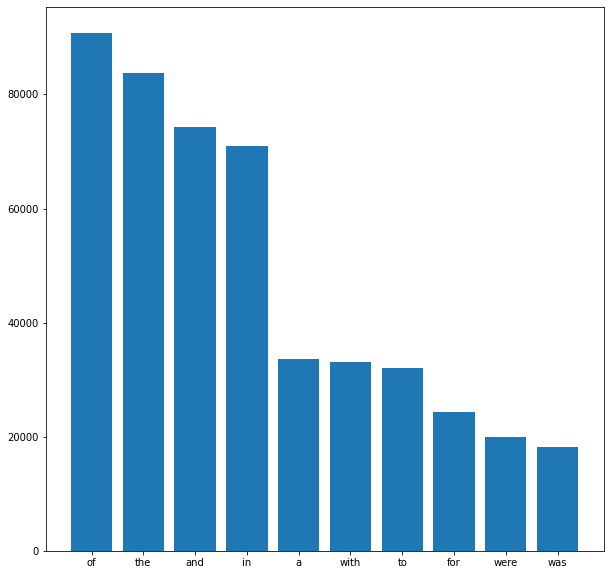

In [42]:
plot_top_stopwords_barchart(train['total'])

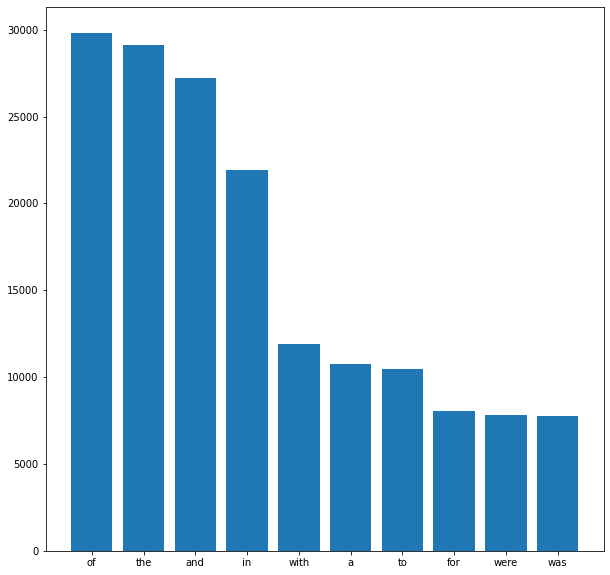

In [43]:
plot_top_stopwords_barchart(test['total'])

In [44]:
import seaborn as sns
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)

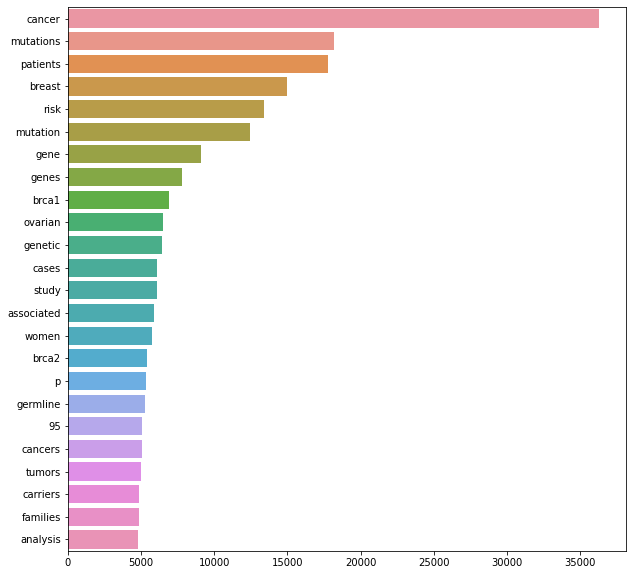

In [45]:
plot_top_non_stopwords_barchart(train['total'])

In [46]:
# Now we remove stopwords 

train['total_tokenize'] = train['total_tokenize'].apply(lambda x: [word for word in x if word not in stop_words])
train['total_tokenize_join'] = [' '.join(map(str, l)) for l in train['total_tokenize']]

train.head()

,pubmedid,Germline,total,total_tokenize,total_tokenize_join
0,26182313,1,hereditary diffuse gastric cancer syndrome cdh...,"[hereditary, diffuse, gastric, cancer, syndrom...",hereditary diffuse gastric cancer syndrome cdh...
1,537637,0,cancer mortality among chinese japanese and in...,"[cancer, mortality, among, chinese, japanese, ...",cancer mortality among chinese japanese indian...
2,861471,0,relative risk of stump cancer following partia...,"[relative, risk, stump, cancer, following, par...",relative risk stump cancer following partial g...
3,1086044,0,endoscopic diagnosis of carcinoma in the opera...,"[endoscopic, diagnosis, carcinoma, operated, s...",endoscopic diagnosis carcinoma operated stomac...
4,31171120,1,hereditary cancer syndromesa primer on diagnos...,"[hereditary, cancer, syndromesa, primer, diagn...",hereditary cancer syndromesa primer diagnosis ...


In [ ]:
#excel_writer = pd.ExcelWriter(r'/content/drive/MyDrive/results3.xlsx')
#train.to_excel(excel_writer, sheet_name='traindata')

#excel_writer.save()

In [47]:
test['total_tokenize'] = test['total_tokenize'].apply(lambda x: [word for word in x if word not in stop_words])
test['total_tokenize_join'] = [' '.join(map(str, l)) for l in test['total_tokenize']]

test.head()

,pubmedid,total,total_tokenize,total_tokenize_join
0,26649820,a mechanism for the suppression of homologous ...,"[mechanism, suppression, homologous, recombina...",mechanism suppression homologous recombination...
1,26654799,pancreatic cancer diagnostics and treatmentcur...,"[pancreatic, cancer, diagnostics, treatmentcur...",pancreatic cancer diagnostics treatmentcurrent...
2,26833090,noncatalytic roles for xpg with brca1 and brca...,"[noncatalytic, roles, xpg, brca1, brca2, homol...",noncatalytic roles xpg brca1 brca2 homologous ...
3,26845227,a rare case of familial multiple subcutaneous ...,"[rare, case, familial, multiple, subcutaneous,...",rare case familial multiple subcutaneous lipom...
4,26873923,targeting brca1 and brca2deficient cells with ...,"[targeting, brca1, brca2deficient, cells, rad5...",targeting brca1 brca2deficient cells rad52 sma...


In [48]:
# Let's evaluate the POS tags for our train set data
tagged_stanzas_train = []
tagged_train = []

for word in train['total_tokenize']:
  tagged_word = nltk.pos_tag(word)
  tagged_stanzas_train.append(tagged_word)

# This format is needed for below visualizer as in takes only two values. If you skip this format, it might give you - "too many values to unpack error" 
tagged_train.append(tagged_stanzas_train)

In [49]:

# Let's evaluate the POS tags for our test set data
tagged_stanzas_test = []
tagged_test = []

for word in test['total_tokenize']:
  tagged_word = nltk.pos_tag(word)
  tagged_stanzas_test.append(tagged_word)

# This format is needed for below visualizer as in takes only two values. If you skip this format, it might give you - "too many values to unpack error" 
tagged_test.append(tagged_stanzas_test)

In [50]:
!pip install -U yellowbrick

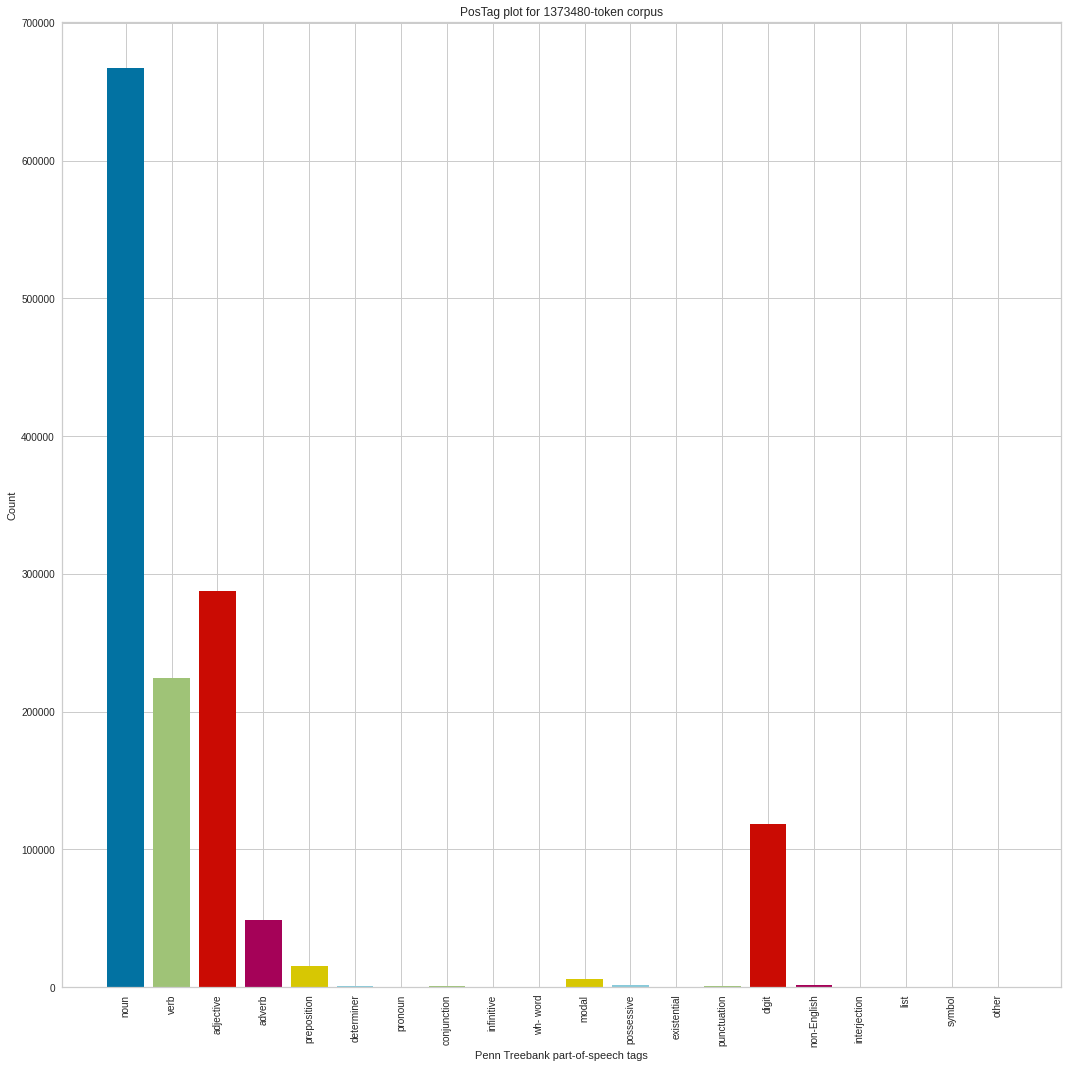

In [51]:
# Create the visualizer for train test

from yellowbrick.text import PosTagVisualizer
plt.figure(figsize=(15,15))
viz = PosTagVisualizer()
viz.fit(tagged_train)
viz.show()

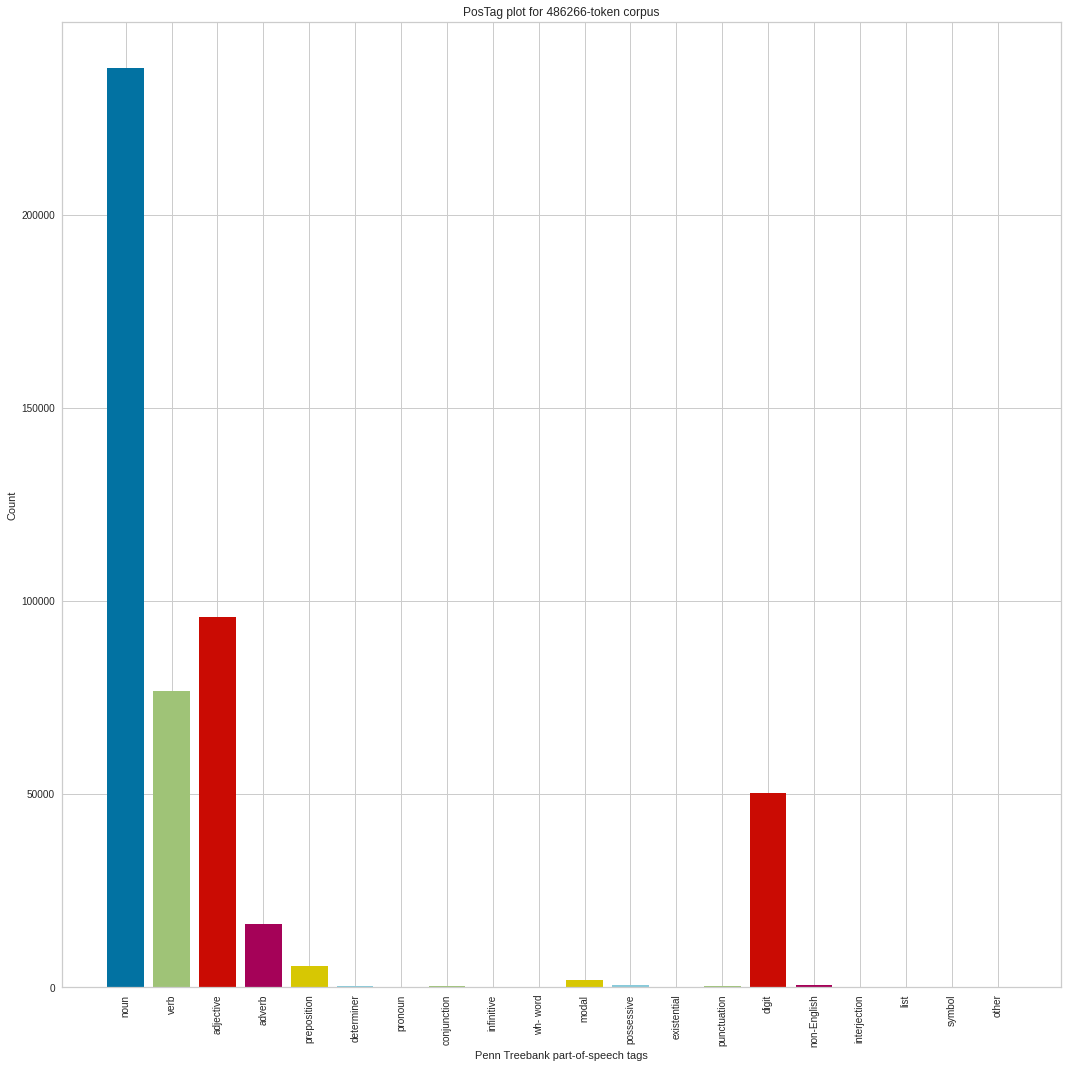

In [52]:
# Create the visualizer for test test

from yellowbrick.text import PosTagVisualizer
plt.figure(figsize=(15,15))
viz = PosTagVisualizer()
viz.fit(tagged_test)
viz.show()

In [53]:
# Now let's check if number of examples for fake vs not-fake label is equal or not. Seems like in this case it's very balanced. 

train.head()


,pubmedid,Germline,total,total_tokenize,total_tokenize_join
0,26182313,1,hereditary diffuse gastric cancer syndrome cdh...,"[hereditary, diffuse, gastric, cancer, syndrom...",hereditary diffuse gastric cancer syndrome cdh...
1,537637,0,cancer mortality among chinese japanese and in...,"[cancer, mortality, among, chinese, japanese, ...",cancer mortality among chinese japanese indian...
2,861471,0,relative risk of stump cancer following partia...,"[relative, risk, stump, cancer, following, par...",relative risk stump cancer following partial g...
3,1086044,0,endoscopic diagnosis of carcinoma in the opera...,"[endoscopic, diagnosis, carcinoma, operated, s...",endoscopic diagnosis carcinoma operated stomac...
4,31171120,1,hereditary cancer syndromesa primer on diagnos...,"[hereditary, cancer, syndromesa, primer, diagn...",hereditary cancer syndromesa primer diagnosis ...


In [54]:
# Now let's check if number of examples for fake vs not-fake label is equal or not. Seems like in this case it's very balanced. 

train["Germline"].value_counts()

1    6098
0    2534
Name: Germline, dtype: int64

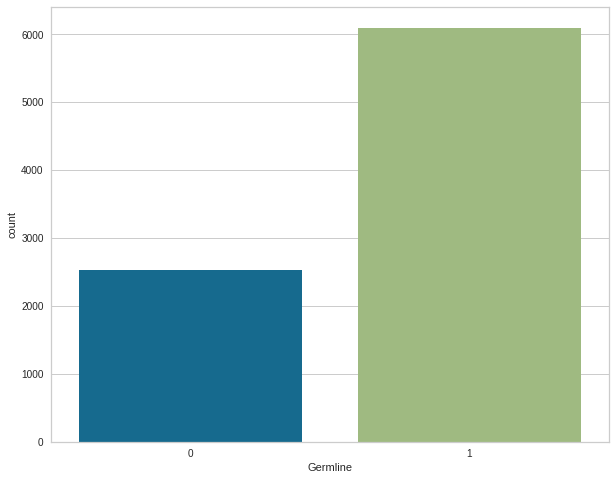

In [55]:
# we see there is an equal number of distribution of target features

rcParams["figure.figsize"] = 10,8
sns.countplot(x = train["Germline"])

In [56]:
# lets extract the label column from train dataframe to be the target 'y' variable
targets = train['Germline'].values

# Drop the 'label' column from train dataset
train.drop("Germline", axis=1, inplace = True)
train.head()

,pubmedid,total,total_tokenize,total_tokenize_join
0,26182313,hereditary diffuse gastric cancer syndrome cdh...,"[hereditary, diffuse, gastric, cancer, syndrom...",hereditary diffuse gastric cancer syndrome cdh...
1,537637,cancer mortality among chinese japanese and in...,"[cancer, mortality, among, chinese, japanese, ...",cancer mortality among chinese japanese indian...
2,861471,relative risk of stump cancer following partia...,"[relative, risk, stump, cancer, following, par...",relative risk stump cancer following partial g...
3,1086044,endoscopic diagnosis of carcinoma in the opera...,"[endoscopic, diagnosis, carcinoma, operated, s...",endoscopic diagnosis carcinoma operated stomac...
4,31171120,hereditary cancer syndromesa primer on diagnos...,"[hereditary, cancer, syndromesa, primer, diagn...",hereditary cancer syndromesa primer diagnosis ...


In [62]:
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))

In [63]:
# fit train data to the count vectorizer
train_counts = count_vectorizer.fit_transform(train['total'].values)

#fit the ngrams count to the tfidf transformers
train_tfidf = transformer.fit_transform(train_counts)

In [64]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers

In [80]:
from sklearn.model_selection import train_test_split
x = train['total'].values
#y = train['Somatic'].values

x_train, x_test, y_train, y_test = \
 train_test_split(x, targets, random_state=0)

In [ ]:
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = \
# train_test_split(train_tfidf, targets, random_state=0 )

In [81]:

tokenizer = Tokenizer(num_words=100)
tokenizer.fit_on_texts(x)
xtrain= tokenizer.texts_to_sequences(x_train)
xtest= tokenizer.texts_to_sequences(x_test)

vocab_size=len(tokenizer.word_index)+1

maxlen=10
xtrain=pad_sequences(xtrain,padding='post', maxlen=maxlen)
xtest=pad_sequences(xtest,padding='post', maxlen=maxlen) 

 

print(x_train[3])
print(xtrain[3])

methionine metabolism regulates maintenance and differentiation of human esips cells embryonic stem es and induced pluripotent stem ips cells are pluripotent and can give rise to all cell types esips cells have a unique transcriptional circuit that sustains the pluripotent state these cells also possess a characteristically high rate of proliferation as well as an abbreviated g1 phase these unique molecular properties distinguish es and ips cells from somatic cells mouse esips cells are in a highflux metabolic state with a high dependence on threonine catabolism however little is known about amino acid metabolism in human esips cells recently we reported that human esips cells require high amounts of methionine met and express high levels of met metabolism enzymes shriaki n et al cell metabolism 2014 met deprivation results in a rapid decrease in intracellular sadenosylmethionine sam triggering the activation of p53 signaling reducing pluripotent marker gene nanog expression and poisin

In [82]:
embedding_dim=50
model=Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
         output_dim=embedding_dim,
         input_length=maxlen))
model.add(layers.LSTM(units=50,return_sequences=True))
model.add(layers.LSTM(units=10))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", 
     metrics=['accuracy'])
model.summary()
model.fit(xtrain,y_train, epochs=20, batch_size=16, verbose=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 50)            2820800   
                                                                 
 lstm_2 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 10)                2440      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,843,537
Trainable params: 2,843,537
No

In [83]:
loss, acc = model.evaluate(xtrain, y_train, verbose=False)
print("Training Accuracy: ", acc)
loss, acc = model.evaluate(xtest, y_test, verbose=False)
print("Test Accuracy: ", acc)

Training Accuracy:  0.7730923891067505
Test Accuracy:  0.7187210321426392


In [70]:
from sklearn.model_selection import train_test_split

#  If train-test size is not initialized, test_size will be set to 0.25 and train_set = 1-test_size

X_train, X_test, y_train, y_test = train_test_split(train_tfidf, targets, random_state=0)



In [71]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [72]:
Extr = ExtraTreesClassifier(n_estimators=5,n_jobs=4)
Extr.fit(X_train, y_train)

print('Accuracy of ExtraTrees classifier on train set: {:.2f}'.format(Extr.score(X_train, y_train)))

print('Accuracy of ExtraTrees classifier on test set: {:.2f}'.format(Extr.score(X_test, y_test)))

Accuracy of ExtraTrees classifier on train set: 1.00
Accuracy of ExtraTrees classifier on test set: 0.78


In [73]:
Adab= AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=5)
Adab.fit(X_train, y_train)

print('Accuracy of Adaboost classifier on training set: {:.2f}'.format(Adab.score(X_train, y_train)))

print('Accuracy of Adaboost classifier on test set: {:.2f}'.format(Adab.score(X_test, y_test)))

Accuracy of Adaboost classifier on training set: 0.86
Accuracy of Adaboost classifier on test set: 0.84


In [74]:
RandomFC= RandomForestClassifier(n_estimators=5)
RandomFC.fit(X_train, y_train)

print('Accuracy of randomforest classifier on training set: {:.2f}'.format(RandomFC.score(X_train, y_train)))

print('Accuracy of randomforest classifier on test set: {:.2f}'.format(RandomFC.score(X_test, y_test)))


Accuracy of randomforest classifier on training set: 0.98
Accuracy of randomforest classifier on test set: 0.77


In [75]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(X_train, y_train)

print('Accuracy of NB  classifier on training set: {:.2f}'.format(NB.score(X_train, y_train)))

print('Accuracy of NB classifier on test set: {:.2f}'.format(NB.score(X_test, y_test)))

Accuracy of NB  classifier on training set: 0.71
Accuracy of NB classifier on test set: 0.70


In [76]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
sgd.fit(X_train, y_train)

print('Accuracy of sgd  classifier on training set: {:.2f}'.format(sgd.score(X_train, y_train)))

print('Accuracy of sgd classifier on test set: {:.2f}'.format(sgd.score(X_test, y_test)))

Accuracy of sgd  classifier on training set: 0.86
Accuracy of sgd classifier on test set: 0.81


In [77]:
from sklearn import model_selection, svm
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train, y_train)

print('Accuracy of SVM  classifier on training set: {:.2f}'.format(SVM.score(X_train, y_train)))

print('Accuracy of SVM classifier on test set: {:.2f}'.format(SVM.score(X_test, y_test)))

Accuracy of SVM  classifier on training set: 0.99
Accuracy of SVM classifier on test set: 0.89


In [78]:
from sklearn.neural_network import MLPClassifier


mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)

mlp.fit(X_train, y_train)

print('Accuracy of MLP  classifier on training set: {:.2f}'.format(mlp.score(X_train, y_train)))

print('Accuracy of MLP classifier on test set: {:.2f}'.format(mlp.score(X_test, y_test)))

Accuracy of MLP  classifier on training set: 1.00
Accuracy of MLP classifier on test set: 0.89


In [79]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

print('Accuracy of Logreg classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))

print('Accuracy of Logreg classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logreg classifier on training set: 1.00
Accuracy of Logreg classifier on test set: 0.90


In [ ]:
# Use score method to get accuracy of model
score = logreg.score(X_test, y_test)
print(score)

0.906858202038925


In [ ]:
# Predict and calculate accuracy
from sklearn.metrics import accuracy_score

predictions = logreg.predict(X_test)
score=accuracy_score(y_test,predictions)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 90.69%


In [ ]:
from sklearn import metrics

CM = metrics.confusion_matrix(y_test, predictions)
print(CM)

[[1431   54]
 [ 147  526]]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [ ]:
print('Recall: %.2f' % recall_score(y_test, predictions))
print('Accuracy: %.2f' % accuracy_score(y_test, predictions))
print('F1 Score: %.2f' % f1_score(y_test, predictions))

Recall: 0.78
Accuracy: 0.91
F1 Score: 0.84


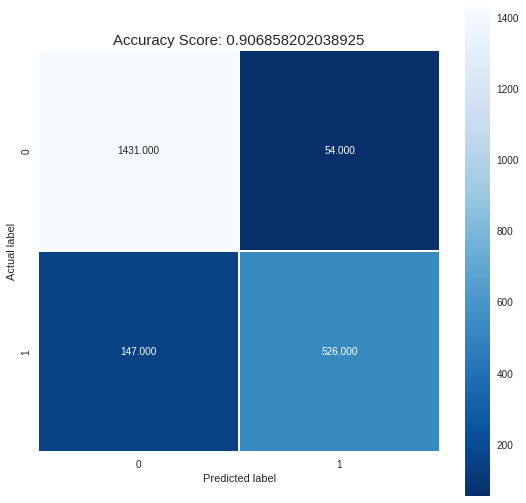

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(CM, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [ ]:
logreg.fit(train_counts, targets)

test_counts = count_vectorizer.transform(test['total'].values)
test_pred = logreg.predict(test_counts)

pred=pd.DataFrame(test_pred, columns=['test_label'])
pred['pubmedid']=test['pubmedid']
pred.groupby('test_label').count()

,pubmedid
test_label,
0,2338
1,562


In [ ]:
excel_writer = pd.ExcelWriter(r'/content/drive/MyDrive/results1.xlsx')
pred.to_excel(excel_writer, sheet_name='prediction')

excel_writer.save()